In [2]:
import os
os.chdir("/Coding/Spectrum4Geo/") #Change to ProjectDirectory (One Directory above)

In [21]:
import pandas as pd
import ast

# Print every correct prediction of the best spectrum4geo approach with Random Sampling

df = pd.read_csv('tools/test_df_with_label_ids_until_hit.csv')
df['label_ids_until_hit'] = df['label_ids_until_hit'].apply(ast.literal_eval)

filtered_df = df[df['label_ids_until_hit'].apply(lambda x: len(x) == 0)]

for index, row in filtered_df.iterrows():
    print(f"index: {index}, key: {row['key']}, description: {row['description']}")

index: 23, key: aporee_40052_45750, description: talk, arabic, alley, womans <br />Recorded by Noam Simner
index: 25, key: aporee_32252_37059, description: Insects sounds,In the bamboo forest edge,<br />Best with Headphone, Proposal to turn up the volume ,<br />Zoom H2n MS+XY ( SoundMap20160504-14) , recorded by Wu,Tsan-Cheng 吳燦政
index: 28, key: aporee_42179_48080, description: redigio.it/datiapo/QGLap o-109-animali.mp3 - Besnate - Cascina Pasque' - 20181211 - Un maiale nero con i suoi sei maialini in atto di allattamento - 1,51
index: 38, key: aporee_41589_47421, description: Recorded on Zoom H4n, build in microphones.
index: 39, key: aporee_16532_20326, description: nan
index: 45, key: aporee_28233_32526, description: Birdsong, Chicken sounds,Frogs chirping, Early morning,<br />Binaural recordings ,Best with Headphone, Proposal to turn up the volume ,<br />Sony PCM D100+ Soundman OKM II ( SoundMap20150611-4) , recorded by Wu,Tsan-Cheng 吳燦政
index: 49, key: aporee_47940_55606, descript

In [5]:
import os
import torch

import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize

from spectrum4geo.model import TimmModel
from spectrum4geo.dataset.evaluation import SatEvalDataset, SpectroEvalDataset
from spectrum4geo.transforms import get_transforms_val_sat, get_transforms_val_spectro 


def extract_checkpoint_info(checkpoint_path):
    print(checkpoint_path)
    # Split the path into parts by '/'
    checkpoint_parts = checkpoint_path.split('/')

    # Find the parts containing relevant information
    mel_kHz_part = next(part for part in checkpoint_parts if part.endswith('kHz')).split('_')
    patch_batch_part = next(part for part in checkpoint_parts if part.endswith('batch_size')).split('_')
    shuffle_part = next(part for part in checkpoint_parts if part.startswith('Shuffle'))

    # Extract values
    n_mels = int(mel_kHz_part[0])
    sr_kHz = int(mel_kHz_part[2].replace('kHz', ''))  # Changed to float to handle values like 22.05
    patch_time_steps = int(patch_batch_part[0])
    batch_size = int(patch_batch_part[3].replace('batch_size', ''))
    shuffle = shuffle_part == 'Shuffle_On'

    return n_mels, sr_kHz, patch_time_steps, batch_size, shuffle

# Configuration settings
@dataclass
class Configuration:
    
    # Model
    model: str = 'convnext_base.fb_in22k_ft_in1k_384'

    checkpoint_start = 'soundingearth/training/128_mel_48_kHz/4096_patch_width_256_batch_size/Shuffle_Off/convnext_base.fb_in22k_ft_in1k_384/020318_0.001_lr_best/weights_end.pth'  
    n_mels, sr_kHz, patch_time_steps, batch_size, shuffle = extract_checkpoint_info(checkpoint_start)

    # Override model image size
    img_size: int = 384                                             # for satallite images
    
    # Evaluation
    batch_size_eval: int = 8
    verbose: bool = True
    gpu_ids: tuple =  (0,1,2,3)       # GPU ids for evaluating
    normalize_features: bool = True

    # Dataset
    data_folder = 'data'        
    evaluate_csv = 'test_df.csv' 

    # set num_workers to 0 if on Windows
    num_workers: int = 0 if os.name == 'nt' else 4 
    
    # train on GPU if available
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu' 

# Instantiate configuration and load model
config = Configuration()

/home/j0kr0017/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


soundingearth/training/128_mel_48_kHz/4096_patch_width_256_batch_size/Shuffle_Off/convnext_base.fb_in22k_ft_in1k_384/020318_0.001_lr_best/weights_end.pth


In [45]:
from torch import nn

print(f'\nModel: {config.model}')

print(f'Used .csv file for evaluating: {config.evaluate_csv}')

model = TimmModel(config.model,
                pretrained=True,
                img_size=config.img_size
                )
                    
data_config = model.get_config()
print(data_config)
mean = data_config['mean']
std = data_config['std']
img_size = config.img_size

img_size_sat = (img_size, img_size)
img_size_spectro = (config.patch_time_steps, config.n_mels)

# load pretrained Checkpoint    
if config.checkpoint_start is not None:  
    print('Start from:', config.checkpoint_start)
    model_state_dict = torch.load(config.checkpoint_start)
    model.load_state_dict(model_state_dict, strict=False)     

# Transformations and dataset loading
spectro_transforms_val = get_transforms_val_spectro(mean=mean,       
                                                    std=std
                                                    )        

sat_transforms_val = get_transforms_val_sat(img_size_sat,
                                            mean=mean,
                                            std=std,
                                            )
        
# Satellite Images (Reference)
sat_dataset_test = SatEvalDataset(data_folder=config.data_folder ,
                                  split_csv=config.evaluate_csv, 
                                  transforms=sat_transforms_val,
                                  )

sat_dataloader_test = DataLoader(sat_dataset_test,
                                 batch_size=config.batch_size_eval,
                                 num_workers=config.num_workers,
                                 shuffle=False,
                                 pin_memory=True
                                 )

spectro_dataset_test = SpectroEvalDataset(data_folder=config.data_folder ,
                                          split_csv=config.evaluate_csv, 
                                          transforms=spectro_transforms_val,
                                          patch_time_steps=config.patch_time_steps,
                                          sr_kHz=config.sr_kHz,
                                          n_mels=config.n_mels,
                                          #stride=stride,
                                          min_frame=None,
                                          chunking=False,
                                          dB_power_weights=False,
                                          use_power_weights=False,
                                          )

spectro_dataloader_test = DataLoader(spectro_dataset_test,
                                     batch_size=config.batch_size_eval,
                                     num_workers=config.num_workers,
                                     shuffle=False,
                                     pin_memory=True,
                                     )        

model = model.to(config.device) 
base_model = model.base_model
base_model.eval()                     
base_model.fc = nn.Linear(512, 2)

for param in base_model.parameters():
    param.requires_grad = True



Model: convnext_base.fb_in22k_ft_in1k_384
Used .csv file for evaluating: test_df.csv
{'input_size': (3, 384, 384), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 1.0, 'crop_mode': 'squash'}
Start from: soundingearth/training/128_mel_48_kHz/4096_patch_width_256_batch_size/Shuffle_Off/convnext_base.fb_in22k_ft_in1k_384/020318_0.001_lr_best/weights_end.pth


In [7]:
def denormalize(tensor):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def plot_cam_model_list_images(model, cam, dataset, index, figwidth, start=None, end=None):
    fig, ax = plt.subplots(1, 1, figsize=(figwidth, 5))  # figwidth is now a parameter

    # Fetch data and process
    item, x = dataset[index]
    print(x.cpu().numpy())

    # Forward pass
    out = model(item.unsqueeze(0).to(config.device))

    # Create a CAM extractor
    activation_map = cam(out.squeeze(0).argmax().item(), out)

    # Move tensors to CPU
    input_tensor_rgb = denormalize(item.to(config.device)).squeeze().permute(1, 2, 0).cpu().numpy()

    # Overlay CAM on the input image
    cam_plot = overlay_mask(to_pil_image(input_tensor_rgb), to_pil_image(activation_map[0].squeeze(0), mode='F'),
                            alpha=0.5)
    
    # Handle slicing if specified
    if start is not None or end is not None:
        cam_plot = cam_plot[:,start:end]

    # Plot the overlayed image
    ax.imshow(cam_plot)
    ax.set_title(f"Heatmap at Index {index}")
    ax.axis('off')

    plt.tight_layout()
    plt.show()

In [62]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
import matplotlib.pyplot as plt
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
import matplotlib.cm as cm
from PIL import Image


def create_sat(index):
    # Initialisierung des CAM-Extractors
    cam_extractor = SmoothGradCAMpp(base_model, target_layer='stages.3.blocks.2.conv_dw')

    dataset = sat_dataset_test

    figwidth = 10
    start = None
    end = None

    # Model processing
    item, x = dataset[index]
    print(x.cpu().numpy())

    item = item.unsqueeze(0).to(config.device)

    # Stellen Sie sicher, dass das Modell im Trainingsmodus ist, falls dies für CAM erforderlich ist
    base_model.train()

    # Verarbeitung Ihrer Daten und Fütterung an das Modell
    out = base_model(item)
    # Abrufen der CAM, indem die Klassenindex und der Modellausgang übergeben werden
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

    img = denormalize(item.to(config.device)).squeeze().permute(1, 2, 0).cpu().numpy()
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.65)

    img = to_pil_image(img)
    fig, axs = plt.subplots(2, 1, figsize=(figwidth, 10))  # figwidth is now a parameter

    # Handle slicing if specified
    if start is not None or end is not None:
        img_width, img_height = result.size
        result = result.crop((start, 0, end, img_height))
        img = img.crop((start, 0, end, img_height))

    # Plotting
    axs[0].imshow(img)
    axs[0].set_title(f"Sat image at {index}")
    axs[0].axis('off')

    axs[1].imshow(result)
    axs[1].set_title(f"Heatmap at Index {index}")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

    dir = 'tools/heats/'
    os.makedirs(dir, exist_ok=True)

    unmasked_img_path = os.path.join(dir, f'{index}_sat_masked_unmasked.png')
    img.save(unmasked_img_path)

    # Maskiertes Bild speichern
    masked_img_path = os.path.join(dir, f'{index}_sat_masked_masked.png')
    result.save(masked_img_path)

In [63]:
def create_spectro(index):

    # Initialisierung des CAM-Extractors
    cam_extractor = SmoothGradCAMpp(base_model, target_layer='stages.3.blocks.2.conv_dw')

    dataset = spectro_dataset_test

    alpha=0.3
    figwidth = 25*2
    figheight = 10*2
    start = 0
    end = 4096

    # Model processing
    item, x = dataset[index]
    print(x.cpu().numpy())

    item = item.unsqueeze(0).to(config.device)

    # Stellen Sie sicher, dass das Modell im Trainingsmodus ist, falls dies für CAM erforderlich ist
    base_model.train()

    # Verarbeitung Ihrer Daten und Fütterung an das Modell
    out = base_model(item)
    # Abrufen der CAM, indem die Klassenindex und der Modellausgang übergeben werden
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    activation = activation_map[0].squeeze(0).cpu().numpy()
    act_pil = to_pil_image(activation, mode='F')

    #-> colormap anwenden auf activation ist ein Array (4, 128)

    img = denormalize(item.to(config.device)).squeeze().permute(1, 2, 0).cpu().numpy()

    # Überlagern Sie die kolorierte Aktivierungskarte auf das ursprüngliche Bild
    result = overlay_mask(to_pil_image(img), act_pil, alpha=alpha, colormap="seismic")

    img = to_pil_image(img)
    fig, axs = plt.subplots(2, 1, figsize=(figwidth, figheight), dpi=300)  # figwidth is now a parameter

    # Handle slicing if specified
    if start is not None or end is not None:
        img_width, img_height = result.size
        result = result.crop((start, 0, end, img_height))
        img = img.crop((start, 0, end, img_height))

    # Plotting
    axs[0].imshow(img)
    axs[0].set_title(f"Sat image at {index}")
    axs[0].axis('off')

    axs[1].imshow(result)
    axs[1].set_title(f"Heatmap at Index {index}")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

    dir = 'tools/heats/'
    os.makedirs(dir, exist_ok=True)

    unmasked_img_path = os.path.join(dir, f'{index}_spectro_masked_unmasked.png')
    img.save(unmasked_img_path)

    # Maskiertes Bild speichern
    masked_img_path = os.path.join(dir, f'{index}_spectro_masked_masked.png')
    result.save(masked_img_path)


In [ ]:
# Printing all layer of convenxt model
for name, _ in base_model.named_modules():
    print(name)

3544


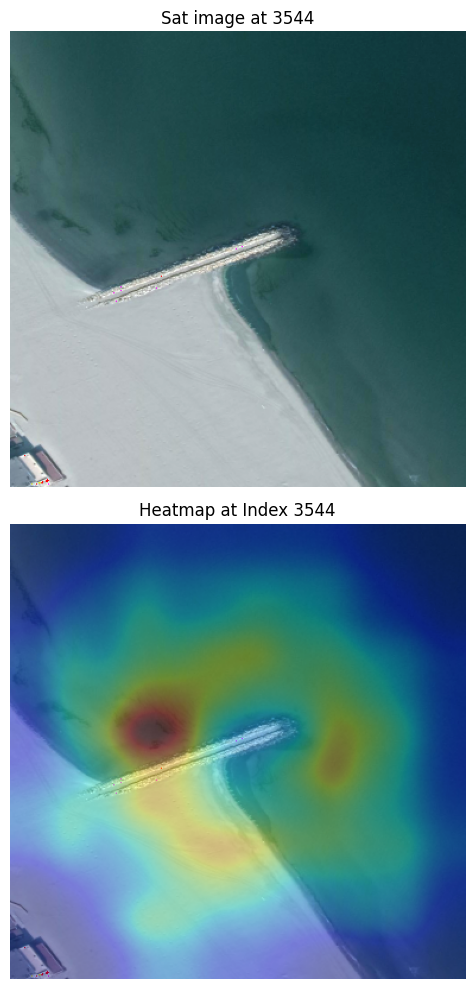

3544


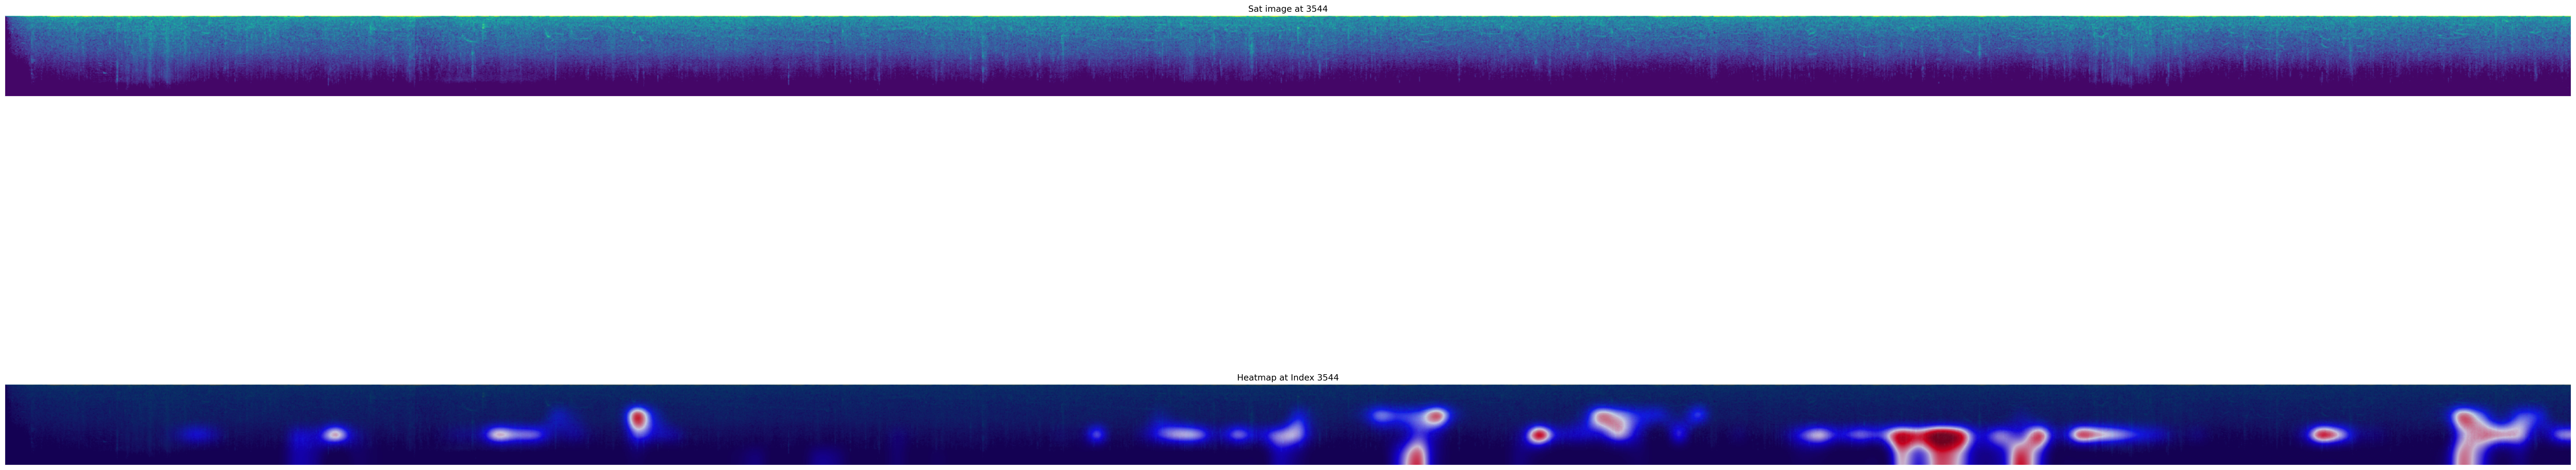

In [72]:
# train index: 74, key: aporee_43107_49136
# ocean 3544

index = 3544
create_sat(index)
create_spectro(index)